## Trying a basic CNN

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch 
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from torchvision.transforms import Resize
import helper
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


data_folder = '/Users/nounou/Desktop/EPFL/M5/Project I/Code/ZooScanSet'


In [2]:
class PlanktonLoader(Dataset):
    """Loads the plankton Classification dataset."""

    def __init__(self, csv_file, image_folder, unwanted_classes = None, transform=None):
        #Trying to delete unwanted files
        try:
            for i in unwanted_classes:  
                shutil.rmtree(data_folder+"/imgs/"+i)
        except (FileNotFoundError):
            pass

        self.data_pre = pd.read_csv(csv_file)
        self.data = self.data_pre[~self.data_pre.taxon.str.contains('|'.join(unwanted_classes))]
        #réindexer
        #self.data.reset_index()
        self.data.index = range(len(self.data))
        self.transform = transform

        # First 2 columns contains the id for the image and the class of the image
        self.dict = self.data.iloc[:,:2].to_dict()
        # When we index we want to get the id
        self.ids = self.dict["objid"]
        print(self.ids[0])
        print(' The id list has a lenght of ', len(self.ids))
        self.classes = self.data["taxon"].unique() # List of unique class name
        # Comparer classes of self.data and the folders on the computer
        
        if set(os.listdir(image_folder)) == set(self.classes) :
            print('ok')
        else:
            print('oops identation broken, the following differs between the list of directories and the class list')
            print(list(set(self.classes) - set(os.listdir(image_folder)) ))
            print(list(set(os.listdir(image_folder))-set(self.classes) ))



        self.class_to_idx = {j: i for i, j in enumerate(self.classes)} 
        #print(self.class_to_idx)
        # Assigns number to every class in the order which it appears in the data
        self.species = self.dict["taxon"]
        # Use this go back to class name from index of the class name
        self.path_plankton = image_folder # Where the images are stored

        print('We have ', len(self.classes), 'classes')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.item()
            assert isinstance(idx, int)

        num = self.ids[idx] # Id of the indexed item
        loc = f"/{num}.jpg"
        #print(loc)
        label = self.dict["taxon"][idx] # Find the label/class of the image at given index
        label_num = self.class_to_idx[label] # Convert it to int
        image = Image.open(self.path_plankton + self.dict["taxon"][idx] + loc)
        if self.transform:
            image = self.transform(image)

        return (image, label, label_num)


In [3]:
image_size = (128,128)
normalize = ((0.5), (0.5))
unwanted_classes = ['seaweed','badfocus__Copepoda','artefact','badfocus__artefact','bubble','detritus','fiber__detritus','egg__other','multiple__other']

transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(), transforms.Normalize(*normalize)])
dataset = PlanktonLoader(data_folder+'/taxa.csv', data_folder+"/imgs/", unwanted_classes ,transform)

print(len(dataset))


14426891
 The id list has a lenght of  703821
ok
We have  84 classes
703821


In [4]:
image_size = (128,128)
normalize = ((0.5), (0.5))
unwanted_classes = ['seaweed','badfocus__Copepoda','artefact','badfocus__artefact','bubble','detritus','fiber__detritus','egg__other','multiple__other']

transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(), transforms.Normalize(*normalize)])
dataset = PlanktonLoader(data_folder+'/taxa.csv', data_folder+"/imgs/", unwanted_classes ,transform)

train_size = int(0.01 * len(dataset)) # 80% of the data to be used for training
test_size = len(dataset) - train_size # The remainder for testing
print('Train set contains', train_size, 'images.')
print('Test set contains', test_size, 'images.')

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Function above takes dataset, and lengths of train,test as input that's what we a supplying here

batch_size = 16
trainloader_dataset = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(trainloader_dataset.dataset))


14426891
 The id list has a lenght of  703821
ok
We have  84 classes
Train set contains 7038 images.
Test set contains 696783 images.
7038


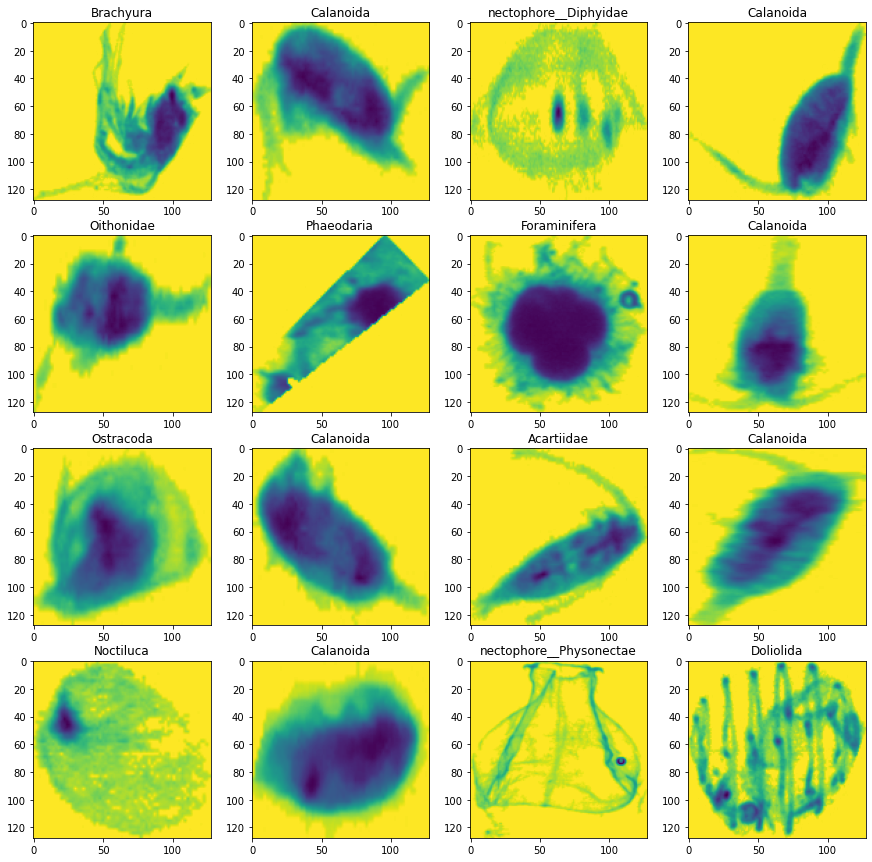

In [ ]:
def subplot_random(trainloader_dataset):
    im, lab, lab_num = next(iter(trainloader_dataset))
    fig=plt.figure(figsize=(15, 15))

    for idx,(i,j) in enumerate(zip(im,lab)):
        idx +=1
        ax = fig.add_subplot(4,4,idx)
        ax.imshow(i.squeeze().numpy())       
        ax.set_title(j)
        #ax.set_title()
    plt.show()

subplot_random(trainloader_dataset) # We plot a batch using this helper function

In [11]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels, label_num = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, label_num) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels, label_num = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, label_num)   # Calculate loss
        acc = accuracy(out, label_num)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
    
        nn.Flatten(),
        nn.Linear(in_features=32 * 32 * 24, out_features=84)
        #Out Features à modifier
        )
            
    def forward(self, xb):
        return torch.log_softmax(self.network(xb), dim=1)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [15]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
model = NaturalSceneClassification()
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, trainloader_dataset, testloader_dataset, opt_func)

 10%|█         | 1/10 [15:01<2:15:09, 901.03s/it]

Epoch [0], train_loss: 2.4822, val_loss: 2.2206, val_acc: 0.4347


 20%|██        | 2/10 [30:15<2:01:13, 909.18s/it]

Epoch [1], train_loss: 1.9427, val_loss: 2.1378, val_acc: 0.4711


 20%|██        | 2/10 [33:16<2:13:04, 998.12s/it]


KeyboardInterrupt: 

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

NameError: name 'history' is not defined

In [ ]:
class Net(nn.Module):
    """
    Class for the network.
    """
    def __init__(self):
        """
        Initializes the network structure.
        """
        super(Net, self).__init__()

        # encoder
        self._block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2))

        self._block2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2))

        # decoder
        self._block3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1))

        self._block4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1))

        self._block5 = nn.Sequential(
            nn.Conv2d(192, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1))

        self._block6 = nn.Sequential(
            nn.Conv2d(131, 128, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initializes weights using He et al. (2015)."""

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        """Through encoder, then decoder by adding U-skip connections. """

        # Encoder
        pool1 = self._block1(x)  # 16
        pool2 = self._block2(pool1)  # 8
        pool3 = self._block2(pool2)  # 4

        # Decoder
        upsample4 = self._block3(pool3)  # 8
        concat4 = torch.cat((upsample4, pool2), dim=1)
        upsample3 = self._block4(concat4)  # 16
        concat3 = torch.cat((upsample3, pool1), dim=1)
        upsample2 = self._block5(concat3)  # 32
        concat1 = torch.cat((upsample2, x), dim=1)

        # Final activation
        return self._block6(concat1)


class Model():
    """
    Class for initializing, training and testing a model.
    """
    def __init__(self) -> None:
        # defining the model
        self.model = Net().to(device)
        # defining the optimizer
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=0.001, betas=[0.9, 0.99], eps=1e-8)
        # defining the loss function
        self.criterion = nn.MSELoss().to(device)

    def load_pretrained_model(self) -> None:
        """
        Loads pretrained model from bestmodel.pth.
        """
        model_path = Path(__file__).parent / "bestmodel.pth"
        checkpoint = torch.load(model_path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    def train(self, train_input, train_target, num_epochs) -> None:
        """
        Trains model on the provided training input and prints its loss for each epoch.
        """
        train_dataset = XYMixerDataset(
            train_input.float(), train_target.float())
        train_loader = DataLoader(
            train_dataset, batch_size=32, shuffle=True)
            
        for epoch in range(num_epochs):
            self.model.train()
            train_losses = []
            for batch_idx, (x_train, y_train) in enumerate(train_loader):
                x_train = x_train.to(device)
                y_train = y_train.to(device)

                # Denoise image
                source_denoised = self.model(x_train)

                # Calculate loss
                loss_train = self.criterion(source_denoised, y_train)
                train_losses.append(loss_train.item())

                # Zero gradients, perform a backward pass, and update the weights
                self.optimizer.zero_grad()
                loss_train.backward()
                self.optimizer.step()
            print('Epoch : ',epoch+1, '\t', 'train-loss :', np.mean(train_losses))

    def predict(self, test_input) -> torch.Tensor:
        """
        Predicts output on the given test_input.
        """
        self.model.eval()
        input_type = test_input.type()
        denoised = self.model(test_input.float().to(device))
        return torch.clamp(denoised, min=0, max=255).type(input_type) # Make sure that the output is between 0-255
